In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#Create pathname
fpath = os.path.join(str(os.getcwd()),'cluster_interview_test.csv')
#Read in file and show head
df = pd.read_csv(fpath)
#For later cluster analysis
kmeans_df = df.copy(deep=True)
df.head()

,user_id,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active
0,5804b63657135c14008b461f12,0.0,0,0,0,0,0,365
1,5815d07a84ab2011338b457764,0.0,0,0,0,0,8,404
2,586959e3a78c4b520e8b464626,0.0,0,0,0,0,2,22
3,58a6c4e1498b23c9028b45e668,0.0,0,0,0,0,6,190
4,58edfc494d19ee1c0000028627,0.0,0,0,0,0,2,180


In [2]:
# Get info on datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
user_id                      10000 non-null object
total_saved_ever             10000 non-null float64
no_of_manual+auto_saves      10000 non-null int64
no_withdrawals               10000 non-null int64
no_auto_saves                10000 non-null int64
no_manual_saves              10000 non-null int64
no_of_cancelled_autosaves    10000 non-null int64
days_active                  10000 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 625.1+ KB


In [3]:
#Check for descriptive stats
df.describe()

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1317.363305,50.65630,9.675100,44.877200,5.779100,5.488300,464.152400
std,1962.265495,35.89763,9.399477,30.610548,13.925318,9.226157,216.698309
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000
25%,249.607500,20.00000,3.000000,18.750000,0.000000,1.000000,351.000000
50%,728.480000,48.00000,7.000000,44.000000,1.000000,2.000000,482.500000
75%,1515.972500,74.00000,14.000000,66.000000,4.000000,6.000000,601.000000
max,21066.090000,233.00000,90.000000,153.000000,155.000000,186.000000,1086.000000


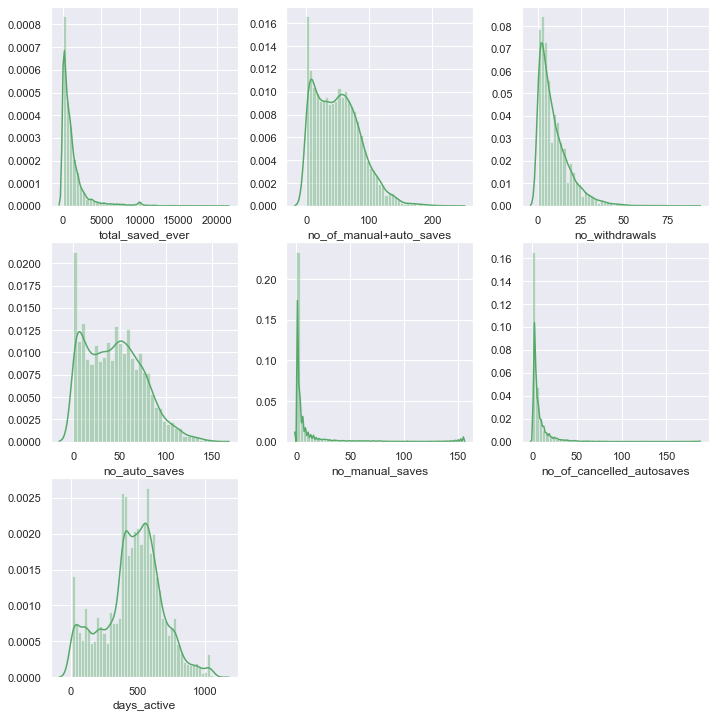

In [4]:
#Review distribution of fields to identify any patterns (EDA)
sns.set()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["g", "#90ee90", "0.7"]) 
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10,10) )
plt.tight_layout()
for i, column in enumerate(df.columns[1:]):
    sns.distplot(df[column],ax=axes[i//3,i%3])
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

# Insights on Fields
### **Total_Saved_ever**: 
* Average saved is 1.3k i.e. average user is worth 1.3k -> this can inform projections of user value (if based on entire dataset), also we can determine outliers using Z-score, IQR, Adjusted Z- score to review customers of low value, high value
* I would tend to use IQR to cluster customers i.e. anything < 25% could drive as customers to target with notifications etc to motivate saving habits (I would also take into account . On the reverse of that, >75% could be used to identify customers that may be more likely to market products to (the more affluent user).
* To make this field more intuitive it would be good to be able to split the amounts by total_save_auto and total_saved_manual.

### **no_manual+auto_saves**:
* Based off of the distribution of data (no_auto_saves seems to consist of the majority of this data, which is expected_. This is corroborated by no_manual_saves with 75% of the customers within this dataset (see cell 3), have 0 manual saves and more than 20% of customers (see histplot)
### **no_auto_saves*:
* The number of customers with 0 autosaves are around ~2% which suggests that there are customers that have enrolled (given that the minimum of days active is 8) but have not linked up to their bank accounts. This could suggest there are issues with linking the app to bank account? However this would require further investigation to confirm.
### *no_manual_saves**: 
* Analysis mentioned above under no_manual+auto_saves
### **no_cancelled_autosaves**:
* <=75% of customers have <=6 cancelled autosaves suggesting the algorithm works well. However there is a max value of 155 and would be interesting to review this customer to understand why they have 155 cancelled autosaves.
### **days_active**:
* Days of activity shows a slight left skew meaning that we have more new customers than old customers (<=25% have used the app for a year). Which may contribute to the higher number of low value per customer

(array([ 810.,  642.,  684., 1231., 1958., 2078., 1363.,  711.,  266.,
         152.,  105.]),
 array([   8.,  106.,  204.,  302.,  400.,  498.,  596.,  694.,  792.,
         890.,  988., 1086.]),
 <a list of 11 Patch objects>)

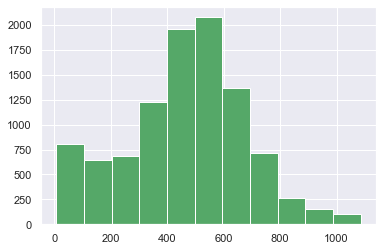

In [5]:
#To review number of days active to help identify cut_points below
plt.hist(df.days_active,bins=11)

In [5]:
#Use binning function to apply cohorts to dataset
def binning(col, cut_points, labels=None):
  #Define min and max values:
    minval = col.min()
    maxval = col.max()

  #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin
#Binning Age
labels = ["new user","mature user","moderately long term user","long term user"]
#Based cut_points off the quartiles generated above
cut_points = [351,483,601]
df['age_of_user'] = binning(df.days_active, cut_points, labels)
#Create additional data for personas of users
df['avg_per_save'] = df['total_saved_ever']/df['no_of_manual+auto_saves']
df['saved_per_day'] = df['total_saved_ever']/df['days_active']
df.groupby('age_of_user').sum()

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,avg_per_save,saved_per_day
age_of_user,,,,,,,,,
new user,688513.00,35838,11571,32359,3479,7084,428757,37778.049924,3894.014593
mature user,3264266.02,114365,21360,97313,17052,12187,1058702,56595.808396,7794.750427
moderately long term user,3963594.35,150424,26665,133352,17072,15133,1346832,56915.850130,7267.368388
long term user,5257259.68,205936,37155,185748,20188,20479,1807233,56561.104943,7247.027659


In [6]:
#Review all relationships between all variables, identify any correlations
data = df.corr(method="pearson")
data.style.background_gradient(cmap='coolwarm').set_precision(4)

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,avg_per_save,saved_per_day
total_saved_ever,1,0.707,0.08254,0.4624,0.8062,-0.03501,0.3558,0.8258,0.9083
no_of_manual+auto_saves,0.707,1,0.351,0.9245,0.5457,0.0574,0.7288,0.4064,0.5359
no_withdrawals,0.08254,0.351,1,0.3684,0.09499,0.3164,0.4308,-0.0395,-0.01383
no_auto_saves,0.4624,0.9245,0.3684,1,0.185,0.05258,0.7717,0.1994,0.2778
no_manual_saves,0.8062,0.5457,0.09499,0.185,1,0.03238,0.1822,0.6022,0.7708
no_of_cancelled_autosaves,-0.03501,0.0574,0.3164,0.05258,0.03238,1,0.2356,-0.07863,-0.0835
days_active,0.3558,0.7288,0.4308,0.7717,0.1822,0.2356,1,0.1466,0.1248
avg_per_save,0.8258,0.4064,-0.0395,0.1994,0.6022,-0.07863,0.1466,1,0.868
saved_per_day,0.9083,0.5359,-0.01383,0.2778,0.7708,-0.0835,0.1248,0.868,1


In [7]:
#Variables of interest noted reviewing everything with 0.5 and more to give an idea of stronger relationships (if any)
corr = data.stack()[(data.stack()!= 1) & (data.stack()>0.5) | (data.stack() <-0.5)]
print(corr)


total_saved_ever         no_of_manual+auto_saves    0.707031
                         no_manual_saves            0.806242
                         avg_per_save               0.825826
                         saved_per_day              0.908315
no_of_manual+auto_saves  total_saved_ever           0.707031
                         no_auto_saves              0.924484
                         no_manual_saves            0.545673
                         days_active                0.728752
                         saved_per_day              0.535915
no_auto_saves            no_of_manual+auto_saves    0.924484
                         days_active                0.771743
no_manual_saves          total_saved_ever           0.806242
                         no_of_manual+auto_saves    0.545673
                         avg_per_save               0.602198
                         saved_per_day              0.770846
days_active              no_of_manual+auto_saves    0.728752
                        

The variables of interest above do not provide any gleaming trends bar that auto saves seem to be more closely correlated with higher totals saved.
I would also have expected total active days to be closely correlated with total_saved_ever however this can be explaned by the fact that give that <=25% of customers have spent under a year on the platform. Another factor to consider, is geography as the  algorithm also takes into account geography, if Chip users are: 
* Lower salaries
* Live in expensive areas
* Younger (therefore less likely to earn higher earnings) - see Fig 10: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/bulletins/annualsurveyofhoursandearnings/2018 


In [8]:
#Assumptions
#Calculate z-scores to identify outliers, >3|<-3 on normalised score = outlier datasets do not follow standardised distribution
#Iglewicz, Boris and David Hoaglin (1993) - 
cols = list(df.columns[1:7])
for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
df.head()
#Outliers not detected, but may prove useful in the future
#Note customers have nothing saved but have been active (worthwile looking into these accounts - people who downloaded but never engaged - Classify customers based off total_saved as opposed to saved per day)

,user_id,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,age_of_user,avg_per_save,saved_per_day,total_saved_ever_zscore,no_of_manual+auto_saves_zscore,no_withdrawals_zscore,no_auto_saves_zscore,no_manual_saves_zscore,no_of_cancelled_autosaves_zscore
0,5804b63657135c14008b461f12,0.0,0,0,0,0,0,365,mature user,NaN,0.0,-0.671382,-1.411203,-1.029375,-1.466143,-0.415027,-0.594893
1,5815d07a84ab2011338b457764,0.0,0,0,0,0,8,404,mature user,NaN,0.0,-0.671382,-1.411203,-1.029375,-1.466143,-0.415027,0.272250
2,586959e3a78c4b520e8b464626,0.0,0,0,0,0,2,22,new user,NaN,0.0,-0.671382,-1.411203,-1.029375,-1.466143,-0.415027,-0.378107
3,58a6c4e1498b23c9028b45e668,0.0,0,0,0,0,6,190,new user,NaN,0.0,-0.671382,-1.411203,-1.029375,-1.466143,-0.415027,0.055465
4,58edfc494d19ee1c0000028627,0.0,0,0,0,0,2,180,new user,NaN,0.0,-0.671382,-1.411203,-1.029375,-1.466143,-0.415027,-0.378107


No outliers detected based off of Z-score results. This would be a useful measure to determine any irregular behavior


(array([0.9033, 0.9585, 0.9779, 0.9895, 0.9974, 0.999 , 0.9997, 0.9998,
        0.9999, 1.    ]),
 array([ 0.     ,  5.27425, 10.5485 , 15.82275, 21.097  , 26.37125,
        31.6455 , 36.91975, 42.194  , 47.46825, 52.7425 ]),
 <a list of 1 Patch objects>)

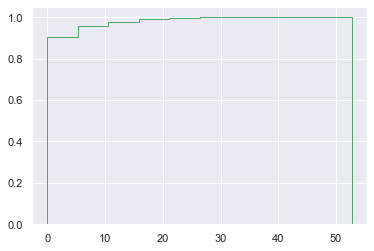

In [9]:
#Review customers based on avg save per day to determine who is high, mid and low value
plt.hist(df.saved_per_day, density=True, histtype='step',
                           cumulative=True)
#Not enough delineation for above field, use total_saved_per_day

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,avg_per_save,saved_per_day,total_saved_ever_zscore,no_of_manual+auto_saves_zscore,no_withdrawals_zscore,no_auto_saves_zscore,no_manual_saves_zscore,no_of_cancelled_autosaves_zscore,avg_saved_yearly
customer_value_type,,,,,,,,,,,,,,,,
very low value,394018.75,43081,15377,40146,2935,15581,911607,24639.435237,1006.963638,-1477.646373,-2327.839706,-937.412817,-2353.783529,-826.790834,201.637908,3.675417e+05
low value,1365828.78,105874,28122,100977,4897,16364,1135594,34832.975691,2980.094896,-982.372606,-578.528122,418.581435,-366.427972,-685.889345,286.509555,1.087735e+06
moderate value,2682014.39,152842,27790,144950,7892,12334,1256741,45562.121894,5318.671218,-311.591090,729.924516,383.258556,1070.174845,-470.802720,-150.313866,1.941315e+06
high value,2972042.77,110614,16987,100529,10085,6793,813936,41803.292181,5483.376834,507.600841,964.723345,263.256522,1085.078950,101.715507,-156.026172,2.001433e+06
very high value,5759728.36,94152,8475,62170,31982,3811,523646,61012.988389,11414.054481,2264.009228,1211.719967,-127.683696,564.957706,1881.767393,-181.807425,4.166130e+06


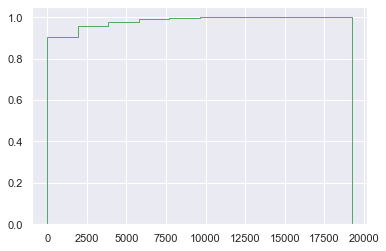

In [10]:
#Generate yearly value based off of avg_saved_day
df['avg_saved_yearly'] = df['saved_per_day']*365
#Plot CDF to see if there are breaks in the data
plt.hist(df.avg_saved_yearly, density=True, histtype='step',
                           cumulative=True)
#Use quartiles to determine value of customers
#very low value = 0-25%, low = 25-50%, moderate 50-75%, high 75-90%, very high 90-100%
lbls = ["very low value","low value","moderate value","high value","very high value"]
quartiles = list(df.avg_saved_yearly.quantile([.25,.5,.75,.90]).values) 
df['customer_value_type'] = binning(df.avg_saved_yearly, quartiles, lbls)
df.sort_values(by='avg_saved_yearly',ascending=False,inplace=True)
df.groupby(['customer_value_type']).sum()

In [11]:
arr = df.groupby(['customer_value_type']).agg({'user_id':'count', 'total_saved_ever':'sum'})
arr.head()

,user_id,total_saved_ever
customer_value_type,,
very low value,2500,394018.75
low value,2500,1365828.78
moderate value,2500,2682014.39
high value,1500,2972042.77
very high value,1000,5759728.36


### Footnote 
* A larger distribution of customers are low value, we could potentially increase (if we were to assume this was the entire dataset) the number of high value customers via targeted advertising. Although barriers for enticing these customers exist in the form of ISAs etc. 
* Nonetheless, for the higher value customers bring in the brunt of the value within this dataset as seen below

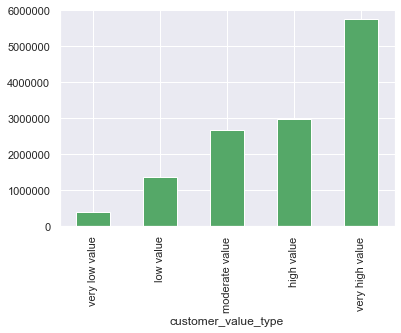

In [12]:
arr['total_saved_ever'].plot(kind="bar")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


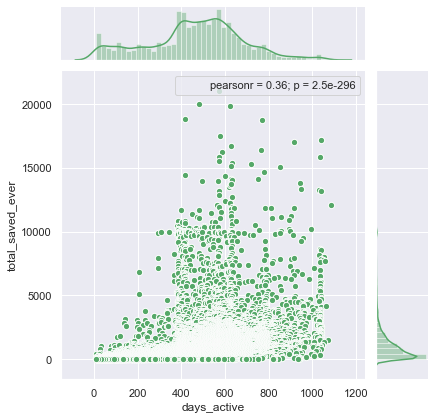

In [13]:
#Review relationship between days_Active and total_saved_Ever based off of findings above
from scipy import stats
g = sns.JointGrid(x="days_active", y="total_saved_ever", data=df)
g = g.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=True, color="g")
g = g.annotate(stats.pearsonr)

#The below demonstrates that days of activity does not strongly correlate (in this dataset) to total_saved. This matches the figure above with 2500 very low value users ()
#This could be improved with further engagement via the app -> increase this with customers who are "very low value and low value"
#Notifications to reduce spending? - Run an A/B Test to see if this affects saving of those customers?

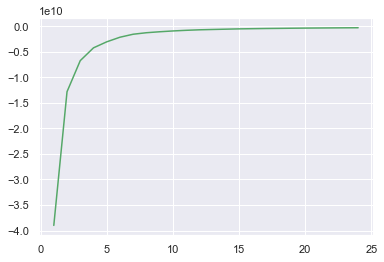

In [14]:
#Utilise Kmeans for clustering and better cohort analysis
# Implementation of the Elbow method for KMeans.
# Using this method to determine in a "scientific" way the best number of cluster to specify to the KMeans algorithm.

# from sklearn.cluster import KMeans

%matplotlib inline

import matplotlib
from sklearn.cluster import KMeans

Ks = range(1, 25)
km = [KMeans(n_clusters=i, random_state=1) for i in Ks]
#Get rid of all null values and fill NaN with 0's
kmeans_df.fillna(0,inplace=True)
my_matrix = kmeans_df._get_numeric_data()
score = [km[i].fit(my_matrix).score(my_matrix) for i in range(len(km))]

plt.plot(Ks, score)
plt.show()

In [15]:
#Further clustering required to identify complete patterns across all variables

#Use num_clusters as 5 based off of the elbow method graph above
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=1)

#Fit and predict clusters from dataset
#Remove non numerical data
new = kmeans_df._get_numeric_data()
km.fit(new)
predict=km.predict(new)
df_kmeans = kmeans_df.copy(deep=True)
df_kmeans['Cluster KMeans'] = pd.Series(predict, index=df_kmeans.index)
#Annualised values of total_saved_ever (NOTE not all customers will have a years worth of data, <25% have under a year of data)
df_kmeans['saved_per_day'] = df_kmeans['total_saved_ever']/df_kmeans['days_active']
df_kmeans['avg_per_save'] = df_kmeans['total_saved_ever']/df_kmeans['no_of_manual+auto_saves']
df_kmeans['annualised_value'] = (df_kmeans['total_saved_ever']/df_kmeans['days_active'])*365
df_kmeans['withdrawal_per_day'] = df_kmeans['no_withdrawals']/df_kmeans['days_active']

#Create cluster labelling to identify cohorts of users
Clusters = {0:"Steady saver",1:"Basic saver",2:"High value savers",3:"Liquid saver",4:"High value squeezed savers"}
df_kmeans['Cluster KMeans'].replace(Clusters,inplace=True)
#Review dataset and apply labelling based off data below 
avg_cluster = df_kmeans.groupby('Cluster KMeans').mean().sort_values(by=['total_saved_ever'],ascending=False)
avg_cluster['% cancelled autosaves'] = (avg_cluster['no_of_cancelled_autosaves']/avg_cluster['no_auto_saves'])*100
#Please note everything is AVERAGED BELOW:
avg_cluster

,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_auto_saves,no_manual_saves,no_of_cancelled_autosaves,days_active,saved_per_day,avg_per_save,annualised_value,withdrawal_per_day,% cancelled autosaves
Cluster KMeans,,,,,,,,,,,,
High value savers,11017.000191,131.918660,6.253589,61.885167,70.033493,2.808612,573.339713,20.401618,86.272997,7446.590685,0.010422,4.538426
High value squeezed savers,6278.909845,107.130435,10.683230,74.822981,32.307453,4.307453,607.916149,11.290994,62.166087,4121.212773,0.017210,5.756859
Steady saver,3034.999244,89.101449,12.289855,77.108696,11.992754,5.452381,627.652174,5.277403,37.187772,1926.252193,0.019493,7.071033
Liquid saver,1333.721540,69.906457,12.477480,65.705827,4.200630,5.841260,577.579843,2.460141,20.539723,897.951450,0.021611,8.890018
Basic saver,315.858836,25.613926,7.604354,24.144520,1.469407,5.460961,353.945008,1.012501,13.222659,369.562754,0.025810,22.617808


In [20]:
#Define groupby object to give relevant fields for analysis
clustercounts = (df_kmeans.groupby(['Cluster KMeans'])
 .agg({'user_id':'nunique', 'total_saved_ever':'sum', 'no_of_manual+auto_saves':'sum','no_withdrawals':'sum','no_of_cancelled_autosaves':'sum'})
 .sort_values(by=['total_saved_ever'],ascending=False) )
#Calculate proportion of customers within each cohort
clustercounts['%prop'] =(clustercounts['user_id']/10000)*100
clustercounts['proportion_of_total_saved'] = (clustercounts['total_saved_ever']/np.sum(clustercounts['total_saved_ever']))*100
clustercounts

,user_id,total_saved_ever,no_of_manual+auto_saves,no_withdrawals,no_of_cancelled_autosaves,%prop,proportion_of_total_saved
Cluster KMeans,,,,,,,
Liquid saver,3175,4234565.89,221953,39616,18546,31.75,32.144253
Steady saver,966,2931809.27,86072,11872,5267,9.66,22.255131
High value savers,209,2302553.04,27571,1307,587,2.09,17.478497
High value squeezed savers,322,2021808.97,34496,3440,1387,3.22,15.347391
Basic saver,5328,1682895.88,136471,40516,29096,53.28,12.774729


# Cluster Summary

## High Value savers (HVS):
* These customers have been active on average for nearly two years (573 days, 3rd most mature group) , have the highest saved per day and avg per save. Notably they have a higher average manual save than the other groups (70 vs 32 - the second highest figure).
* They also present with the highest annualised value compared to the other cohorts. As such I would expect these users to have the most disposable income.
* These types of customers are mature and have on average used the app for 573 days - I would suggest this cohort should have a retention policy applied to ensure they remain customers as they present 17% of the total value in this dataset.
* The lower number of withdrawals also suggests that these customers are saving for longer term goals potentially larger purchases i.e. homes - we could substantiate this with a goal tag (i.e. when they save is there an option to choose what they're saving for?). **This would also be a brilliant method to market products to these customers i.e. if they choose holiday, provide deals via the app too**. 
* To further substantiate the category naming I would need to have time series data with a field such as time to withdrawal?
* This customer group despite their small proportion (2.09%) rank 3rd in terms of value by total_saved_ever 

## High value squeezed savers (HVSS) :
* This cohort has similar activity to their sister group (607 days active) but despite that have a much lower annualised value. This could be influenced by greater number of days active however their avg_per_save is 25% lower than the high value savers (HVS) , suggesting otherwise. As such I would expect this group to have less disposable income than the (HVS) group.
* Their withdrawal numbers (3rd highest average withdrawal count, 10.68) could also be due to shorter term saving goals ? Once again i would require average time till withdrawal to corroborate this but the withdrawals_per_day are suggestive. 
* This cohort is also small like there sister group (High Value savers) but have a higher (almost 3x) no_withdrawals and cancelled autosaves, possibly due to a financial squeeze hence the "squeezed savers" suffix.

## Steady saver (SS)
* With a significantly lower annualised value vs the two previous groups (£1926 vs £4121 (HVSS) and £7446 (HVS)), suggesting this group would fall within a lower wage bracket than the two previous. Geography once again could also be another factor as real incomes vary from city to city. (Demographic data required to confirm)
* Compromising a slightly higher volume of customer (9.66%) and producing an average total_saved_ever 3k per person and annualised average value of ~2k.
* They likely have smaller saving goals due to high number of withdrawals but also likely lack the disposable income required to meet their savings goals noted by the 7% of their autosaves being cancelled. Whether this is due to spending habits would be discernible by having track of their balance at the time of withdrawal/cancelled autosaves.

## Liquid saver (LS)
* Second largest group (31.75%) within the dataset producing the largest value within the dataset with volatile behaviours in terms of their high number of withdrawals and cancelled autosaves. 
* Given the value (32%) this should be considered a prime group to maintain if this is a representative sample of the current client base.
* Additional value could be driven within this group if behaviours can be changed and converted toward the HS type although this would be very difficult to achieve especially with customers living in expensive areas and low real incomes. 
* Alternatively, if the app provides insights on their withdrawal behaviour this could potentially reduce the number of withdrawals/cancelled autosaves. Another route is to diminish the amount saved within this group of members.

## Basic Saver (BS)
* The core group (53.3%) of this dataset are represented by low value customers who seem to "struggle" to save or are testing the app out.
* They produce the lowest avg annualised saved as well as the total saved ever. 
* The data suggests this group possess the lowest disposable income and once again this could be further corroborated by access to data on their bank balances.
* This group seem less interested or find it harder to save noted by their high cancelled autosaves % (~22%).
* Based on analysis above, this group should have the lowest avg_per_Save (which they do) suggesting the algorithm is working as expected, however, some consideration should be put on whether or not it is cost effective given the large number of withdrawals/autosave cancellations? Does this operation cost to carry out or not? 
* I would also class this group as the most save sensitive (i.e. amount leaving their account to have the biggest impact on the user) as such particular attention should be paid to the amount debited to improve retention.

# Further questions i would want to ask
* Is the value higher for manual auto saves vs no_auto_saves vs manual saves? 
* Are cancelled autosaves linked with proximity to overdraft? This could help determine performance of the algorithm
* Regarding no_withdrawals -> average saved per day before withdrawal vs avg saved per day post withdrawal? Is there a difference, this would help identify customers who are single goal/short term savers vs long term savers
* Customers that are active but have not saved -> are there reasons behind this? Is there any survey data for this?